In [2]:
import torch
from torch import nn
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

In [3]:
import requests
import zipfile
from pathlib import Path


data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"


if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    

    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)


    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


In [4]:
import os
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir('/content/data')

There are 1 directories and 1 images in '/content/data'.
There are 2 directories and 0 images in '/content/data/pizza_steak_sushi'.
There are 3 directories and 0 images in '/content/data/pizza_steak_sushi/train'.
There are 0 directories and 72 images in '/content/data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in '/content/data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 75 images in '/content/data/pizza_steak_sushi/train/steak'.
There are 3 directories and 0 images in '/content/data/pizza_steak_sushi/test'.
There are 0 directories and 31 images in '/content/data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in '/content/data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 19 images in '/content/data/pizza_steak_sushi/test/steak'.


In [5]:
train_dir = '/content/data/pizza_steak_sushi/train'
test_dir = '/content/data/pizza_steak_sushi/test'

Random image path: data/pizza_steak_sushi/train/sushi/2021685.jpg
Image class: sushi
Image height: 384
Image width: 512


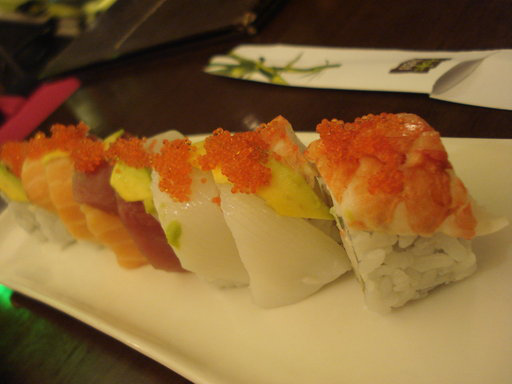

In [6]:
import random
from PIL import Image


random.seed(42) 


image_path_list = list(image_path.glob("*/*/*.jpg"))


random_image_path = random.choice(image_path_list)


image_class = random_image_path.parent.stem


img = Image.open(random_image_path)


print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

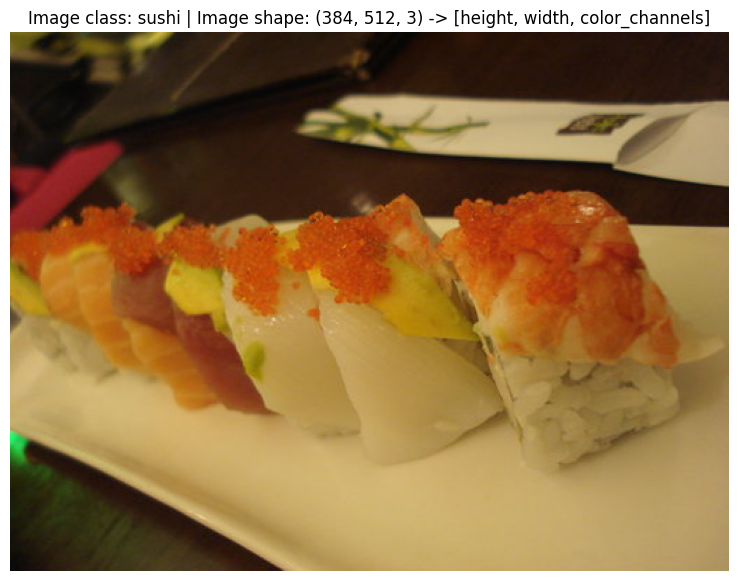

In [7]:

import numpy as np
import matplotlib.pyplot as plt


img_as_array = np.asarray(img)


plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

In [8]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [9]:
data_transform = transforms.Compose([
    
    transforms.Resize(size=(64, 64)),
    
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.ToTensor() 
])

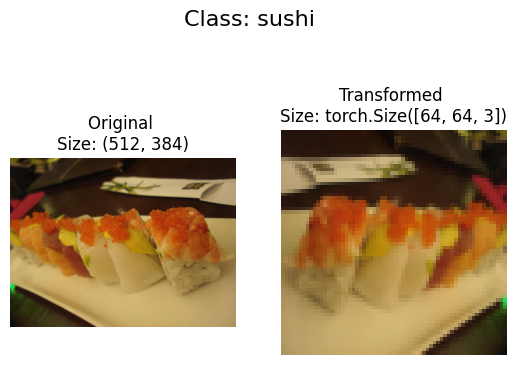

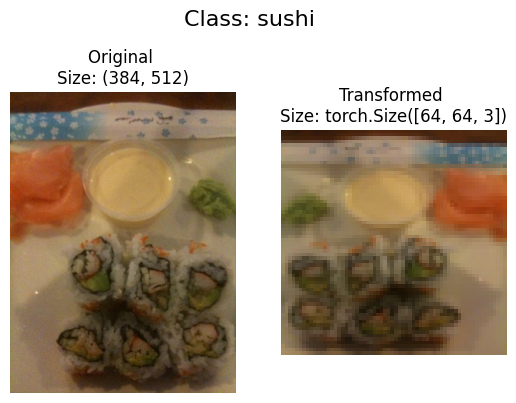

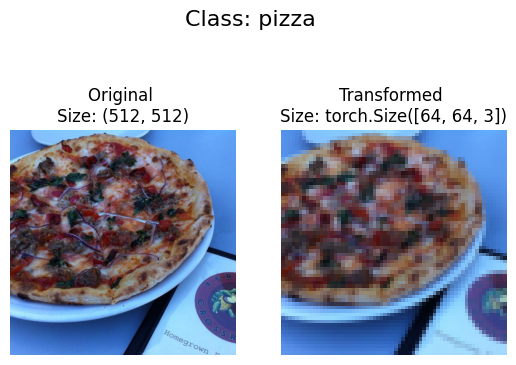

In [10]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

          
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, 
                        transform=data_transform, 
                        n=3)

In [11]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [12]:
def find_classes(directory: str):
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
  if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")

  class_to_idx = {cls_name : i for i , cls_name in enumerate(classes)}
  return classes , class_to_idx

find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [13]:
class Custom_Datasets(Dataset):
  def __init__(self,target_dir: str ,transform):
    self.paths = list(pathlib.Path(target_dir).glob("*/*.jpg"))
    self.transform = transform
    self.classes , self.class_to_idx= find_classes(target_dir)

  def load_image(self, index: int):
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path) 

  def __len__(self) -> int:
        return len(self.paths)

  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        img = self.load_image(index)
        class_name  = self.paths[index].parent.name # expects path in data_folder/class_name/image.jpeg
        class_idx = self.class_to_idx[class_name]

        
        if self.transform:
            return self.transform(img), class_idx # return data, label (X, y)
        else:
            return img, class_idx # return data, label (X, y)

In [14]:
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])


test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [35]:
train_data_custom = Custom_Datasets(target_dir=train_dir, 
                                      transform=auto_transforms)
test_data_custom = Custom_Datasets(target_dir=test_dir, 
                                     transform=auto_transforms)
train_data_custom, test_data_custom

(<__main__.Custom_Datasets at 0x7f41fe7edbd0>,
 <__main__.Custom_Datasets at 0x7f42dc542200>)

In [16]:
len(train_data_custom),len(test_data_custom)

(225, 75)

In [17]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [18]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [19]:
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    
    
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    
    
    if seed:
        random.seed(seed)

    
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    
    plt.figure(figsize=(16, 8))

    
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        
        targ_image_adjust = targ_image.permute(1, 2, 0)

        
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.


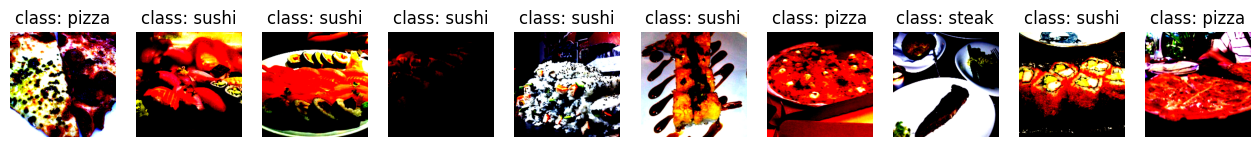

In [36]:
display_random_images(train_data_custom, 
                      n=12, 
                      classes=train_data_custom.classes,seed=None)

In [37]:
train_dataloader_custom = DataLoader(dataset=train_data_custom, 
                                     batch_size=32, 
                                     num_workers=0,
                                     shuffle=True) 

test_dataloader_custom = DataLoader(dataset=test_data_custom, 
                                    batch_size=32, 
                                    num_workers=0, 
                                    shuffle=False) 

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7f41fe68fb50>,
 <torch.utils.data.dataloader.DataLoader at 0x7f41fe68c850>)

In [38]:
img , label = next(iter(train_dataloader_custom))
img_single, label_single = img[0].unsqueeze(dim=0), label[0]
print(img_single.shape)
print(label_single)
print(label_single.shape)
print(img.shape)
print(label)
print(label.shape)

torch.Size([1, 3, 224, 224])
tensor(0)
torch.Size([])
torch.Size([32, 3, 224, 224])
tensor([0, 1, 1, 2, 0, 1, 1, 0, 2, 2, 0, 0, 1, 2, 2, 1, 0, 1, 0, 2, 0, 2, 1, 1,
        2, 1, 1, 2, 2, 2, 1, 2])
torch.Size([32])


In [23]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3,
                      stride=1, 
                      padding=1), 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) 
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )
    def forward(self, x: torch.Tensor):
        
        return self.classifier(self.conv_block_2(self.conv_block_1(x)))
        
        

torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, 
                  hidden_units=10, 
                  output_shape=len(train_data_custom.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [24]:
try: 
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo
    
from torchinfo import summary
summary(model_0,input_size=[32, 3, 64, 64]) 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 3]                   --
├─Sequential: 1-1                        [32, 10, 32, 32]          --
│    └─Conv2d: 2-1                       [32, 10, 64, 64]          280
│    └─ReLU: 2-2                         [32, 10, 64, 64]          --
│    └─Conv2d: 2-3                       [32, 10, 64, 64]          910
│    └─ReLU: 2-4                         [32, 10, 64, 64]          --
│    └─MaxPool2d: 2-5                    [32, 10, 32, 32]          --
├─Sequential: 1-2                        [32, 10, 16, 16]          --
│    └─Conv2d: 2-6                       [32, 10, 32, 32]          910
│    └─ReLU: 2-7                         [32, 10, 32, 32]          --
│    └─Conv2d: 2-8                       [32, 10, 32, 32]          910
│    └─ReLU: 2-9                         [32, 10, 32, 32]          --
│    └─MaxPool2d: 2-10                   [32, 10, 16, 16]          --
├─Sequentia

In [28]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    
    model.train()
    
    
    train_loss, train_acc = 0, 0
    
    
    for batch, (X, y) in enumerate(dataloader):
        
        X, y = X.to(device), y.to(device)

        
        y_pred = model(X)

        
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        
        optimizer.zero_grad()

        
        loss.backward()

        
        optimizer.step()

        
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [25]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    
    model.eval() 
    
    
    test_loss, test_acc = 0, 0
    
    
    with torch.inference_mode():
        
        for batch, (X, y) in enumerate(dataloader):
            
            X, y = X.to(device), y.to(device)
    

            test_pred_logits = model(X)

            
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
      
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [26]:
from tqdm.auto import tqdm


def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
   
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
  
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

    
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

In [29]:
torch.manual_seed(42) 
torch.cuda.manual_seed(42)


NUM_EPOCHS = 15

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

model_0_results = train(model=model_0, 
                        train_dataloader=train_dataloader_custom,
                        test_dataloader=test_dataloader_custom,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1156 | train_acc: 0.2734 | test_loss: 1.1009 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.1139 | train_acc: 0.2812 | test_loss: 1.1083 | test_acc: 0.3229
Epoch: 3 | train_loss: 1.1022 | train_acc: 0.2812 | test_loss: 1.0956 | test_acc: 0.3229
Epoch: 4 | train_loss: 1.1081 | train_acc: 0.3242 | test_loss: 1.0907 | test_acc: 0.4167
Epoch: 5 | train_loss: 1.0947 | train_acc: 0.4141 | test_loss: 1.0945 | test_acc: 0.4167
Epoch: 6 | train_loss: 1.1064 | train_acc: 0.2930 | test_loss: 1.0941 | test_acc: 0.4167
Epoch: 7 | train_loss: 1.0936 | train_acc: 0.4141 | test_loss: 1.0943 | test_acc: 0.4167
Epoch: 8 | train_loss: 1.1064 | train_acc: 0.2930 | test_loss: 1.0922 | test_acc: 0.4167
Epoch: 9 | train_loss: 1.0964 | train_acc: 0.4102 | test_loss: 1.0988 | test_acc: 0.2396
Epoch: 10 | train_loss: 1.0665 | train_acc: 0.4297 | test_loss: 1.1402 | test_acc: 0.2604
Epoch: 11 | train_loss: 1.0757 | train_acc: 0.4258 | test_loss: 1.1379 | test_acc: 0.2604
Epoch: 12 | train_l

In [30]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    
    loss = results['train_loss']
    test_loss = results['test_loss']

    
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    
    epochs = range(len(results['train_loss']))

    
    plt.figure(figsize=(15, 7))

    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

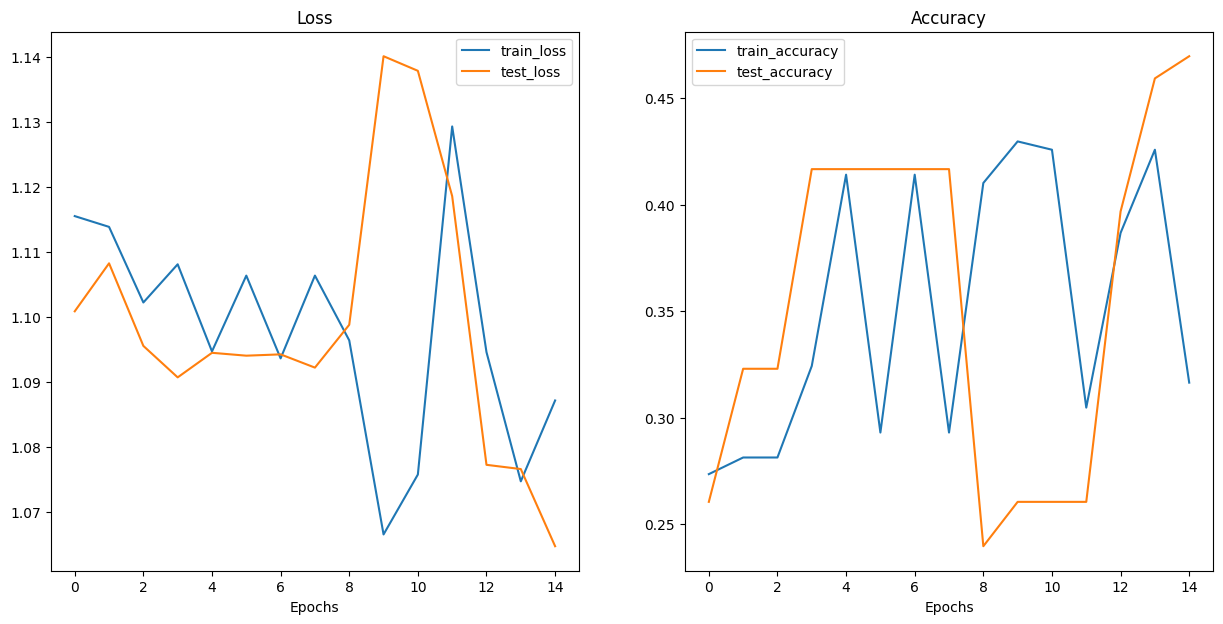

In [31]:
plot_loss_curves(model_0_results)

**using transefer learning**

In [33]:
import torchvision
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights


EfficientNet_B0_Weights.IMAGENET1K_V1

In [34]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [39]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT  
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 193MB/s]


In [40]:
summary(model=model, 
        input_size=(32, 3, 224, 224),
        
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [41]:
for param in model.features.parameters():
    param.requires_grad = False

In [42]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)


output_shape = len(train_data_custom.classes)


model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [43]:
summary(model, 
        input_size=(32, 3, 224, 224), 
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [46]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

torch.manual_seed(42)
torch.cuda.manual_seed(42)


from timeit import default_timer as timer 
start_time = timer()


results = train(model=model,
                       train_dataloader=train_dataloader_custom,
                       test_dataloader=test_dataloader_custom,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5)


end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0651 | train_acc: 0.3555 | test_loss: 0.8223 | test_acc: 0.8229
Epoch: 2 | train_loss: 0.8462 | train_acc: 0.7461 | test_loss: 0.6943 | test_acc: 0.8958
Epoch: 3 | train_loss: 0.7476 | train_acc: 0.7461 | test_loss: 0.6304 | test_acc: 0.9167
Epoch: 4 | train_loss: 0.7545 | train_acc: 0.7266 | test_loss: 0.5616 | test_acc: 0.9167
Epoch: 5 | train_loss: 0.6686 | train_acc: 0.7734 | test_loss: 0.5517 | test_acc: 0.8958
[INFO] Total training time: 16.571 seconds


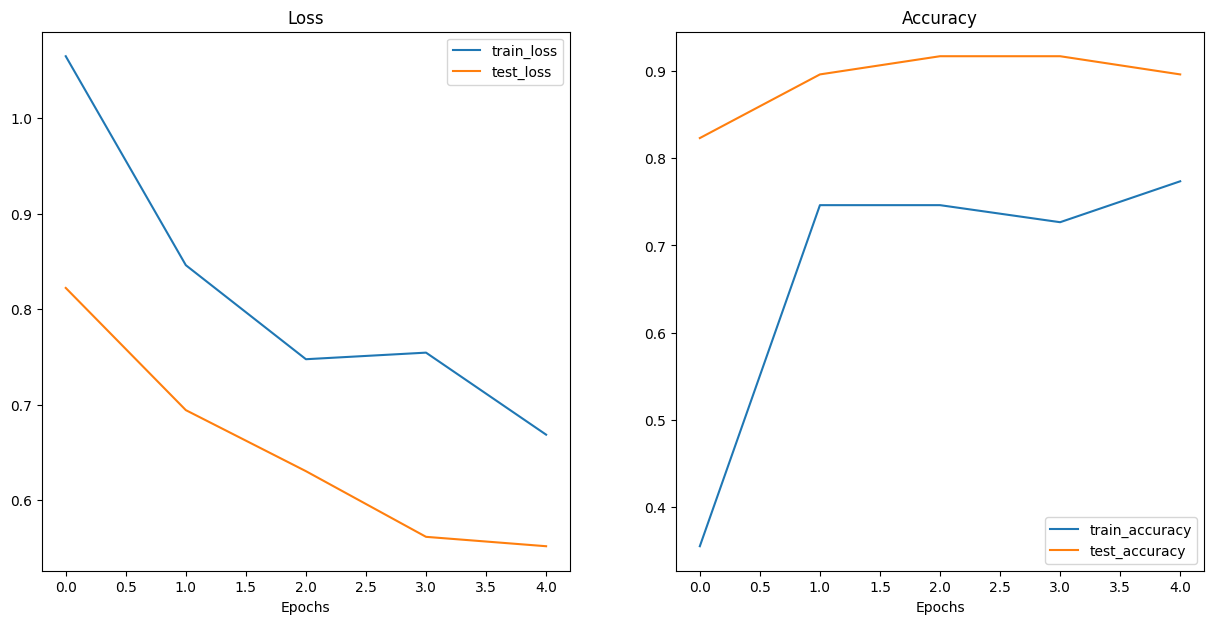

In [47]:
plot_loss_curves(results)

In [48]:
from typing import List, Tuple

from PIL import Image


def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str, 
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
    
    
    
    img = Image.open(image_path)

    
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])


    
    model.to(device)

    
    model.eval()
    with torch.inference_mode():
      
      transformed_image = image_transform(img).unsqueeze(dim=0)

      
      target_image_pred = model(transformed_image.to(device))

    
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

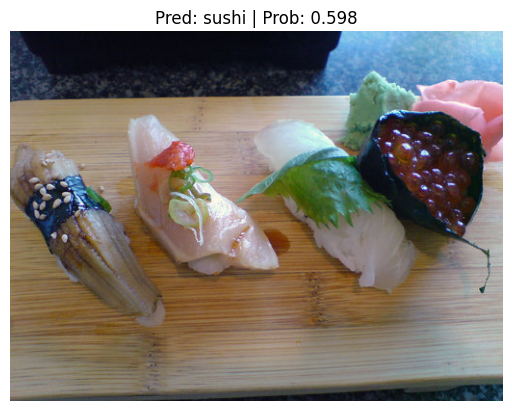

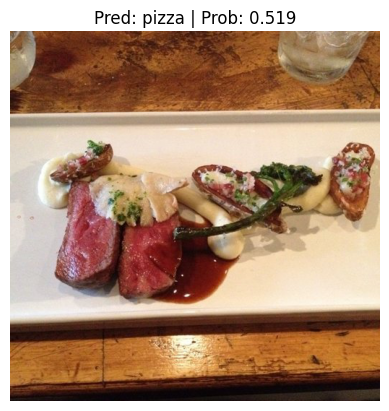

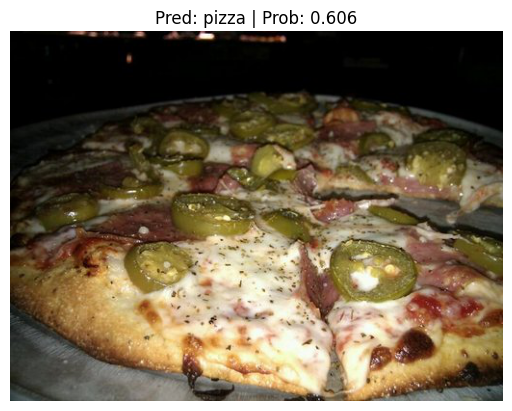

In [50]:
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))  
test_image_path_sample = random.sample(population=test_image_path_list, 
                                       k=num_images_to_plot) 


for image_path in test_image_path_sample:
    pred_and_plot_image(model=model, 
                        image_path=image_path,
                        class_names=train_data_custom.classes,
                        image_size=(224, 224))

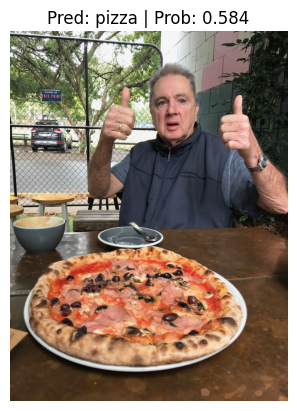

In [51]:
import requests


custom_image_path = data_path / "04-pizza-dad.jpeg"


if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")


class_names=train_data_custom.classes
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)

In [52]:
from tqdm.auto import tqdm


y_preds = []
model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader_custom, desc="Making predictions"):
    
    X, y = X.to(device), y.to(device)
    
    y_logit = model(X)
    
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
    
    y_preds.append(y_pred.cpu())

y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/3 [00:00<?, ?it/s]

In [53]:
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend 
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 68.1 MB/s eta 0:00:00
mlxtend version: 0.22.0


In [54]:
import mlxtend 
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19

0.22.0


In [60]:
y_labels = []
for batch, (X, y) in enumerate(test_dataloader_custom):
  y_labels.append(y)

y_labels_tensor = torch.cat(y_labels)

print(y_labels_tensor)
print(y_pred_tensor)

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1])
tensor([2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2,
        1, 2, 2, 2, 2, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1])


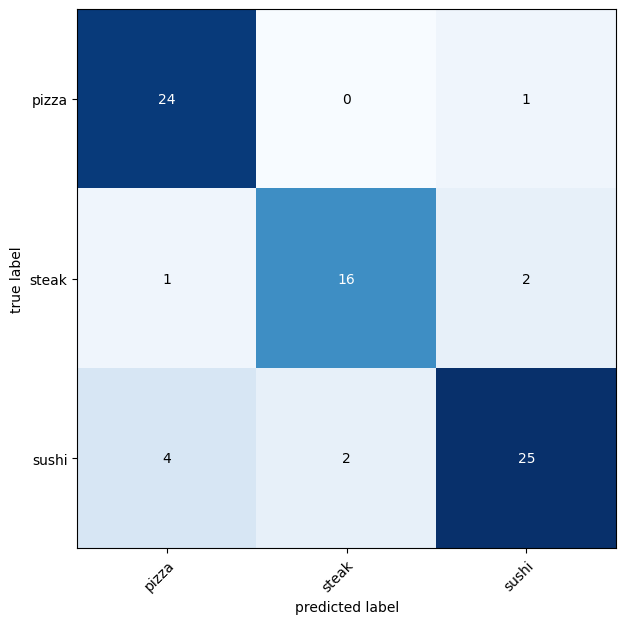

In [61]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix


confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=y_labels_tensor)


fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), 
    class_names=class_names, 
    figsize=(10, 7)
);